This notebook follows
https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-1-dimensional-function-from-scratch-in-keras/

In [6]:
from numpy.random import rand, choice
from numpy import hstack
from matplotlib import pyplot
from numpy.random import poisson
import requests
import numpy as np
import io

url = 'https://github.com/JeffersonLab/jlab_datascience_data/blob/main/eICU_age.npy?raw=true'
response = requests.get(url)
response.raise_for_status()
a = np.load(io.BytesIO(response.content))

def gen_fake(n, a=a):
  m = len(a)
  a = poisson(20, m)

  y = np.zeros((n, 1))
  a = a[:n]
  a = np.vstack(a)
  return a, y
def gen_real(n, a=a):
  y = np.ones((n, 1))
  a = choice(a, n)
  a = np.asarray([x[0] for x in a]).reshape(len(a),1)
  return a, y

In [ ]:
# define the discriminator model
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
 
# define the standalone discriminator model
def define_discriminator(n_inputs=1):
	model = Sequential()
	model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model
 
# define the discriminator model
model = define_discriminator()

def train_discriminator(model, n_epochs=1000, n_batch=128):
	half_batch = int(n_batch / 2)
	# run epochs manually
	for i in range(n_epochs):
		# generate real examples
		X_real, y_real = gen_real(half_batch)
		# update model
		model.train_on_batch(X_real, y_real)
		# generate fake examples
		X_fake, y_fake = gen_fake(half_batch)
		# update model
		model.train_on_batch(X_fake, y_fake)
		# evaluate the model
		_, acc_real = model.evaluate(X_real, y_real, verbose=0)
		_, acc_fake = model.evaluate(X_fake, y_fake, verbose=0)
		print(i, acc_real, acc_fake)

# fit the model
train_discriminator(model)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 15)                90        
                                                                 
 dense_7 (Dense)             (None, 1)                 16        
                                                                 
Total params: 106
Trainable params: 106
Non-trainable params: 0
_________________________________________________________________


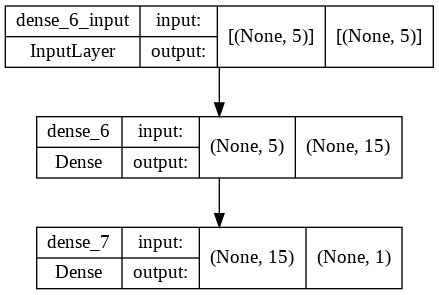

In [8]:
# define the standalone generator model
def define_generator(latent_dim, n_outputs=1):
	model = Sequential()
	model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
	model.add(Dense(n_outputs, activation='linear'))
	return model
  
# define the discriminator model
model = define_generator(5)
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

Number of epochs: 9999
Number of real samples: 500
Number of generated samples: 500


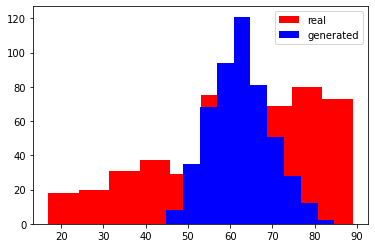

In [11]:
# train a generative adversarial network on a one-dimensional function
from numpy import hstack
from numpy import zeros
from numpy import ones
from numpy.random import rand
from numpy.random import randn
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
 
# define the standalone discriminator model
def define_discriminator(n_inputs=1):
	model = Sequential()
	model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model
 
# define the standalone generator model
def define_generator(latent_dim, n_outputs=1):
	model = Sequential()
	model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
	model.add(Dense(n_outputs, activation='linear'))
	return model
 
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam')
	return model
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
	# generate points in the latent space
	x_input = gen_fake(latent_dim * n)[0]
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n, latent_dim)
	return x_input
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels
	y = zeros((n, 1))
	return X, y
 
# evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, latent_dim, n=500):
	# prepare real samples
	x_real, y_real = gen_real(n)
	# evaluate discriminator on real examples
	_, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
	# evaluate discriminator on fake examples
	_, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
	# Histogram plot real and fake data points
	print("Number of epochs:", epoch)
	print("Number of real samples:", len(x_real))
	print("Number of generated samples:", len(x_fake))
	plt.hist(x_real, color='red')
	plt.hist(x_fake, color='blue')
	labels= ["real","generated"]
	plt.legend(labels)
	plt.show()
 
# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=128):
	# determine half the size of one batch, for updating the discriminator
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# prepare real samples
		x_real, y_real = gen_real(half_batch)
		# prepare fake examples
		x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
		# update discriminator
		d_model.train_on_batch(x_real, y_real)
		d_model.train_on_batch(x_fake, y_fake)
		# prepare points in latent space as input for the generator
		x_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = ones((n_batch, 1))
		# update the generator via the discriminator's error
		gan_model.train_on_batch(x_gan, y_gan)
		# evaluate the model every n_eval epochs
	summarize_performance(i, g_model, d_model, latent_dim)
 
# size of the latent space
latent_dim = 5
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# train model
train(generator, discriminator, gan_model, latent_dim)

In [31]:
n_gen = 500
s = generate_fake_samples(generator, 5, n_gen)[0].reshape(1,n_gen).astype(int)
print(s)

[[63 72 52 76 73 55 60 63 57 53 63 66 64 63 65 61 69 64 57 56 55 61 55 59
  57 63 54 65 76 61 55 57 75 72 51 72 58 64 58 75 59 73 55 59 63 50 64 71
  57 65 67 73 64 67 72 73 60 70 74 60 60 64 54 53 48 54 71 63 66 66 53 72
  57 76 69 62 67 78 64 69 66 56 64 64 59 55 68 71 67 66 58 62 69 61 73 61
  57 71 56 62 63 64 53 57 64 59 70 67 55 60 54 48 61 56 68 56 65 63 47 64
  76 67 68 48 60 65 68 53 61 56 59 58 60 72 67 63 62 53 60 70 61 70 68 77
  56 62 55 53 67 51 79 55 45 63 62 55 67 50 61 56 65 60 53 69 60 54 74 54
  71 54 64 60 68 58 53 72 64 62 64 51 51 52 59 64 57 79 54 55 62 55 59 74
  54 67 70 58 55 60 65 64 71 67 67 76 74 66 58 70 54 58 54 71 62 62 60 56
  68 64 57 55 54 55 73 48 67 62 66 62 71 58 65 70 69 74 63 67 60 61 61 65
  62 70 53 55 64 66 60 60 73 53 65 59 73 64 59 73 59 68 59 59 67 63 66 49
  69 54 61 62 69 57 64 74 64 72 63 58 55 61 66 73 66 69 58 68 66 64 67 61
  66 50 52 55 67 59 70 53 59 66 72 64 59 58 61 62 69 61 62 65 60 69 59 61
  80 67 61 52 74 66 66 72 76 68 52 70 